In [2]:
import pandas as pd
df = pd.read_csv('test2.csv')
codebook = pd.read_csv('codebook.csv')

In [3]:
# remove the data not in Jan 2022 - Jan 2025
df['create_date_et'] = pd.to_datetime(df['create_date_et'], errors = 'coerce')

start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2025-01-31')

df_2225 = df[(df['create_date_et'] >= start_date) & (df['create_date_et'] <= end_date)]
df_2225 = df_2225.sort_values(by='create_date_et', ascending=False)
print("Any out-of-range dates?", ((df_2225['create_date_et'] < start_date) | (df_2225['create_date_et'] > end_date)).any())

Any out-of-range dates? False


In [4]:
# for consistency, change request type name so it is similar to the codebook
df_2225 = df_2225.merge(codebook[['request_type_id', 'issue']], on='request_type_id', how='left')
df_2225.drop(columns=['request_type_name'], inplace=True)
df_2225.rename(columns={'issue': 'request_type_name'}, inplace=True) 
df_2225.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_id,create_date_et,create_date_utc,...,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,request_type_name
0,813886,925468,1,t,closed,1,Police - Zones 1-6,297,2025-01-30 23:43:00,2025-01-31T04:43:00,...,Pittsburgh,Greenfield,4.200315e+10,5.0,15.0,4.0,40.420077,-79.930352,APPROXIMATE,Excessive Noise/Disturbances
1,813885,925467,1,t,closed,1,Pittsburgh Water and Sewer Authority,532,2025-01-30 22:43:00,2025-01-31T03:43:00,...,Pittsburgh,Perry South,NaN,6.0,26.0,1.0,40.470502,-80.017537,EXACT,Water Main Break
2,813884,925466,1,f,in progress,3,DPW - Street Maintenance,484,2025-01-30 21:45:00,2025-01-31T02:45:00,...,Pittsburgh,Shadyside,NaN,8.0,7.0,4.0,40.451474,-79.930616,EXACT,Potholes
3,813883,925465,1,f,in progress,3,DPW - Street Maintenance,484,2025-01-30 20:07:00,2025-01-31T01:07:00,...,Pittsburgh,East Liberty,NaN,9.0,8.0,5.0,40.462655,-79.928434,EXACT,Potholes
4,813881,925464,1,f,open,0,Police - AVU,415,2025-01-30 19:57:00,2025-01-31T00:57:00,...,Pittsburgh,Perry South,4.200325e+10,6.0,26.0,1.0,40.467660,-80.004072,APPROXIMATE,Abandoned Vehicle (parked on street)


In [5]:
# number of duplicate group_id
duplicate_count = df_2225[df_2225.duplicated(subset='group_id')].shape[0]
print(f"Number of duplicate 'group_id' values: {duplicate_count}")

# remove duplicates in group_id
df_2225 = df_2225.drop_duplicates(subset='group_id', keep='first')

# check for any duplicates in the group_id
duplicates = df_2225[df_2225.duplicated(subset='group_id', keep=False)]

if not duplicates.empty:
    print("Duplicates remaining:")
    print(duplicates)
else:
    print("All duplicates removed.")

Number of duplicate 'group_id' values: 14210
All duplicates removed.


In [6]:
# only include rows with city == Pittsburgh since they cannot reach those outside city limits
df_2225 = df_2225[df_2225['city'] == 'Pittsburgh']

In [7]:
# add a resolution_time column that shows the days it took to close a request
df_2225['closed_date_et'] = pd.to_datetime(df_2225['closed_date_et'], errors='coerce')
df_2225['resolution_time'] = (df_2225['closed_date_et'] - df_2225['create_date_et']).dt.days
df_2225.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_id,create_date_et,create_date_utc,...,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,request_type_name,resolution_time
0,813886,925468,1,t,closed,1,Police - Zones 1-6,297,2025-01-30 23:43:00,2025-01-31T04:43:00,...,Greenfield,4.200315e+10,5.0,15.0,4.0,40.420077,-79.930352,APPROXIMATE,Excessive Noise/Disturbances,3.0
1,813885,925467,1,t,closed,1,Pittsburgh Water and Sewer Authority,532,2025-01-30 22:43:00,2025-01-31T03:43:00,...,Perry South,NaN,6.0,26.0,1.0,40.470502,-80.017537,EXACT,Water Main Break,0.0
2,813884,925466,1,f,in progress,3,DPW - Street Maintenance,484,2025-01-30 21:45:00,2025-01-31T02:45:00,...,Shadyside,NaN,8.0,7.0,4.0,40.451474,-79.930616,EXACT,Potholes,NaN
3,813883,925465,1,f,in progress,3,DPW - Street Maintenance,484,2025-01-30 20:07:00,2025-01-31T01:07:00,...,East Liberty,NaN,9.0,8.0,5.0,40.462655,-79.928434,EXACT,Potholes,NaN
4,813881,925464,1,f,open,0,Police - AVU,415,2025-01-30 19:57:00,2025-01-31T00:57:00,...,Perry South,4.200325e+10,6.0,26.0,1.0,40.467660,-80.004072,APPROXIMATE,Abandoned Vehicle (parked on street),NaN


In [8]:
# create a new column that shows status for all the values that are not closed
df_2225['is_closed'] = df_2225['status_code'].map({1: 1, 0: 0, 3: 0, 4: 0})

# create a new column that shows the public access level of issue
df_2225 = pd.merge(df_2225, codebook[['request_type_id', 'public_access_level']], on='request_type_id', how='left')

df_2225.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_id,create_date_et,create_date_utc,...,council_district,ward,police_zone,latitude,longitude,geo_accuracy,request_type_name,resolution_time,is_closed,public_access_level
0,813886,925468,1,t,closed,1,Police - Zones 1-6,297,2025-01-30 23:43:00,2025-01-31T04:43:00,...,5.0,15.0,4.0,40.420077,-79.930352,APPROXIMATE,Excessive Noise/Disturbances,3.0,1,Neighborhood
1,813885,925467,1,t,closed,1,Pittsburgh Water and Sewer Authority,532,2025-01-30 22:43:00,2025-01-31T03:43:00,...,6.0,26.0,1.0,40.470502,-80.017537,EXACT,Water Main Break,0.0,1,Block Level
2,813884,925466,1,f,in progress,3,DPW - Street Maintenance,484,2025-01-30 21:45:00,2025-01-31T02:45:00,...,8.0,7.0,4.0,40.451474,-79.930616,EXACT,Potholes,NaN,0,Block Level
3,813883,925465,1,f,in progress,3,DPW - Street Maintenance,484,2025-01-30 20:07:00,2025-01-31T01:07:00,...,9.0,8.0,5.0,40.462655,-79.928434,EXACT,Potholes,NaN,0,Block Level
4,813881,925464,1,f,open,0,Police - AVU,415,2025-01-30 19:57:00,2025-01-31T00:57:00,...,6.0,26.0,1.0,40.467660,-80.004072,APPROXIMATE,Abandoned Vehicle (parked on street),NaN,0,Neighborhood


In [9]:
#change null to date April 6 (day of download) and create a new column with no nulls
fill_date = pd.to_datetime('2025-04-06')
df_2225['closed_date_filled'] = df_2225['closed_date_et'].fillna(fill_date)
df_2225['resolution_time_filled'] = (df_2225['closed_date_filled'] - df_2225['create_date_et']).dt.days

# create multi-class column that shows open for more than 30 days and less than 30 days
def classify_status(row):
    if row['resolution_time_filled'] >= 30:
        return 'more than 30 days'
    else:
        return 'less than 30 days'
        
# create a column that shows if request is open for more than 30 days
df_2225['request_status'] = df_2225.apply(classify_status, axis=1)

# check
df_2225[['resolution_time_filled', 'request_status']].head()

,resolution_time_filled,request_status
0,3,less than 30 days
1,0,less than 30 days
2,65,more than 30 days
3,65,more than 30 days
4,65,more than 30 days


In [10]:
# count the number of rows in df_2225 dataframe
print(f"Number of rows: ", len(df_2225))

# count the number of missing values and status requests
null_count = df_2225['request_status'].isnull().sum()
print(f"\nNumber of null values in 'request_status': {null_count}")

## create_data_et
null_count = df_2225['create_date_et'].isnull().sum()
print(f"\nNumber of null values in 'create_date_et': {null_count}")

## closed_data_et
null_count = df_2225['closed_date_et'].isnull().sum()
print(f"\nNumber of null values in 'closed_date_et': {null_count}")

## request_type_name
null_count = df_2225['request_type_name'].isnull().sum()
print(f"\nNumber of null values in 'request_type_name': {null_count}")

## request_type_id
null_count = df_2225['request_type_id'].isnull().sum()
print(f"\nNumber of null values in 'request_type_id': {null_count}")

## dept
null_count = df_2225['dept'].isnull().sum()
print(f"\nNumber of null values in 'dept': {null_count}")

## public access level
null_count = df_2225['public_access_level'].isnull().sum()
print(f"\nNumber of null values in 'public_access_level': {null_count}")

## origin of request
null_count = df_2225['origin'].isnull().sum()
print(f"\nNumber of null values in 'origin': {null_count}")

## resolution_time
null_count = df_2225['resolution_time'].isnull().sum()
print(f"\nNumber of null values in 'resolution_time': {null_count}")

## council_district
null_count = df_2225['council_district'].isnull().sum()
print(f"\nNumber of null values in 'council_district': {null_count}")

## neighborhood
null_count = df_2225['neighborhood'].isnull().sum()
print(f"\nNumber of null values in 'neighborhood': {null_count}")

Number of rows:  316673

Number of null values in 'request_status': 0

Number of null values in 'create_date_et': 0

Number of null values in 'closed_date_et': 50225

Number of null values in 'request_type_name': 5477

Number of null values in 'request_type_id': 0

Number of null values in 'dept': 1452

Number of null values in 'public_access_level': 18097

Number of null values in 'origin': 0

Number of null values in 'resolution_time': 50225

Number of null values in 'council_district': 18490

Number of null values in 'neighborhood': 19288


In [11]:
# counts of request status
status = df_2225['request_status'].value_counts()
print("Counts of requests by status:")
print(status)

## number of open and closed request
closed_counts = df_2225['is_closed'].value_counts()
print("\nCounts of requests by status:")
print(closed_counts)

## number of in_progress, on-hold, open, and closed requests
closed_counts = df_2225['status_name'].value_counts()
print("\nCounts of requests by status:")
print(closed_counts)

Counts of requests by status:
request_status
less than 30 days    206056
more than 30 days    110617
Name: count, dtype: int64

Counts of requests by status:
is_closed
1    266448
0     50225
Name: count, dtype: int64

Counts of requests by status:
status_name
closed         266448
open            31454
in progress     18421
on hold           350
Name: count, dtype: int64


In [12]:
# delete unnecessary columns and export csv file
df_2225.drop(columns=['parent_closed', 'create_date_utc', 'last_action_utc', 'closed_date_utc', 'street', 'cross_street', 'street_id', 'cross_street_id',
                      'city', 'census_tract', 'ward', 'police_zone', 'latitude', 'longitude', 'geo_accuracy'], inplace=True)

df_2225.to_csv('clean1.csv', index=False)

In [13]:
# save as csv file
df_2225.to_csv('clean2.csv', index=False)

DESCRIPTIVE ANALYSIS - Neighborhood

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

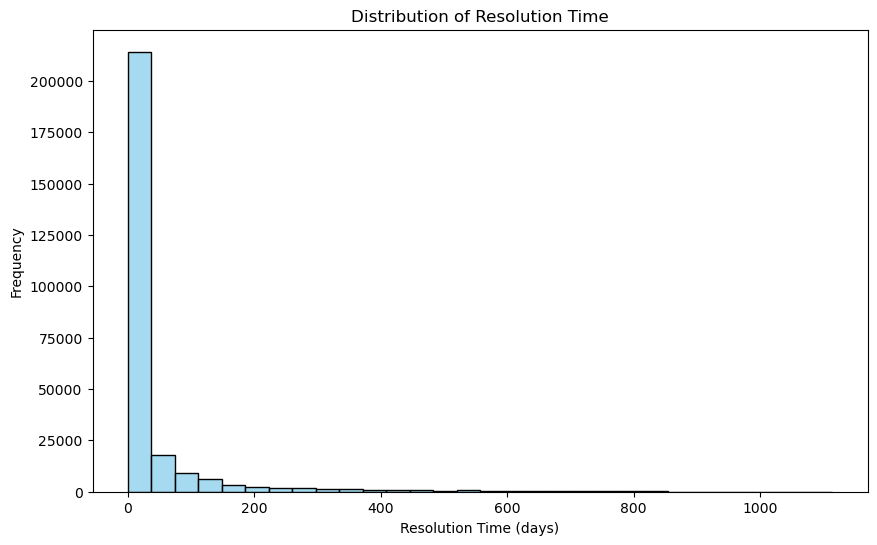


Minimum resolution time: 0.0 days
Maximum resolution time: 1114.0 days


<Figure size 640x480 with 0 Axes>

In [15]:
#distribution of resolution time
plt.figure(figsize=(10, 6))
sns.histplot(df_2225['resolution_time'], kde=False, bins=30, color='skyblue')
plt.title('Distribution of Resolution Time')
plt.xlabel('Resolution Time (days)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('dist_restime.png', format='png', bbox_inches='tight')

min_resolution_time = df_2225['resolution_time'].min()
max_resolution_time = df_2225['resolution_time'].max()

print(f"\nMinimum resolution time: {min_resolution_time} days")
print(f"Maximum resolution time: {max_resolution_time} days")

In [16]:
# calulate average resolution time
avg_resolution_time = df_2225['resolution_time'].mean()
print(f"The average time to close a ticket is {avg_resolution_time: .2f} days.")

The average time to close a ticket is  39.69 days.


In [17]:
# neighborhood vs resolution time
neigh_res = df_2225.groupby('neighborhood')['resolution_time'].mean().reset_index()
neigh_res = neigh_res.sort_values(by='resolution_time', ascending=False)
print(neigh_res.head())

        neighborhood  resolution_time
56     North Oakland        81.580721
57       North Shore        70.393593
0   Allegheny Center        66.886963
42     Homewood West        64.492084
63      Point Breeze        62.332492


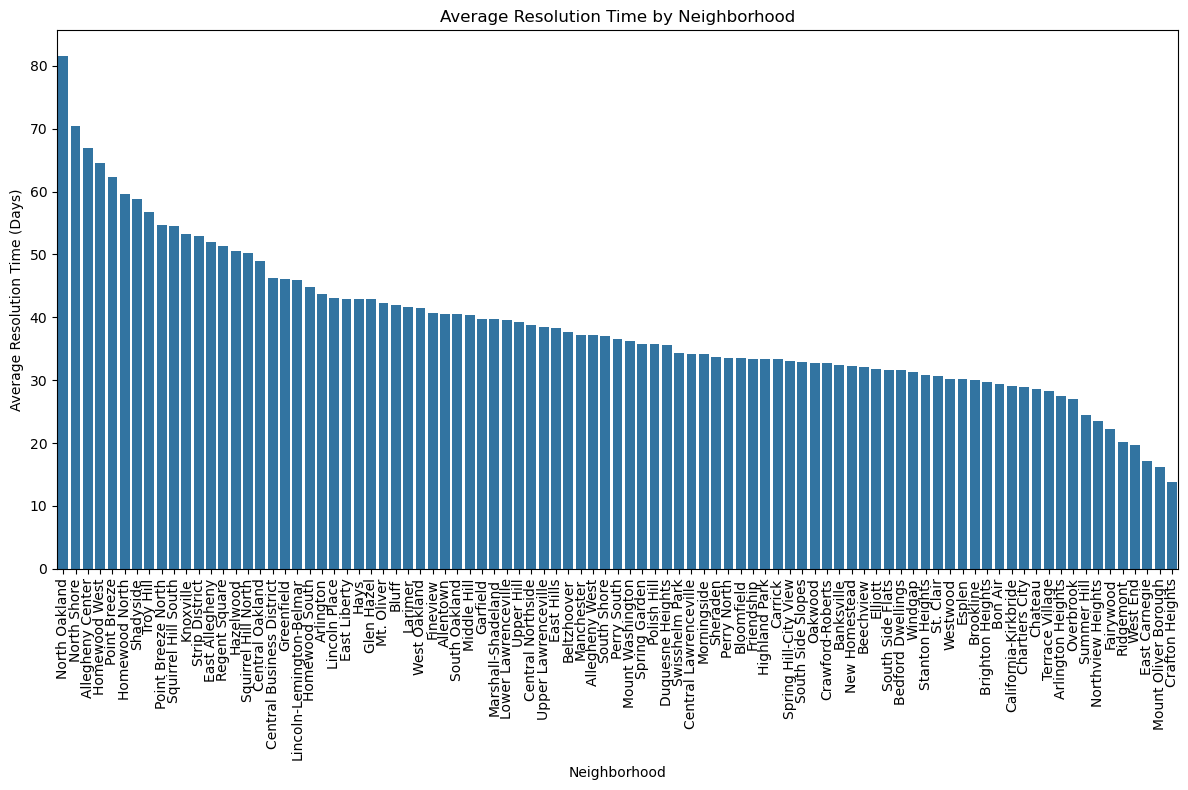

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(data=neigh_res, x='neighborhood', y='resolution_time')

plt.title('Average Resolution Time by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Resolution Time (Days)')
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

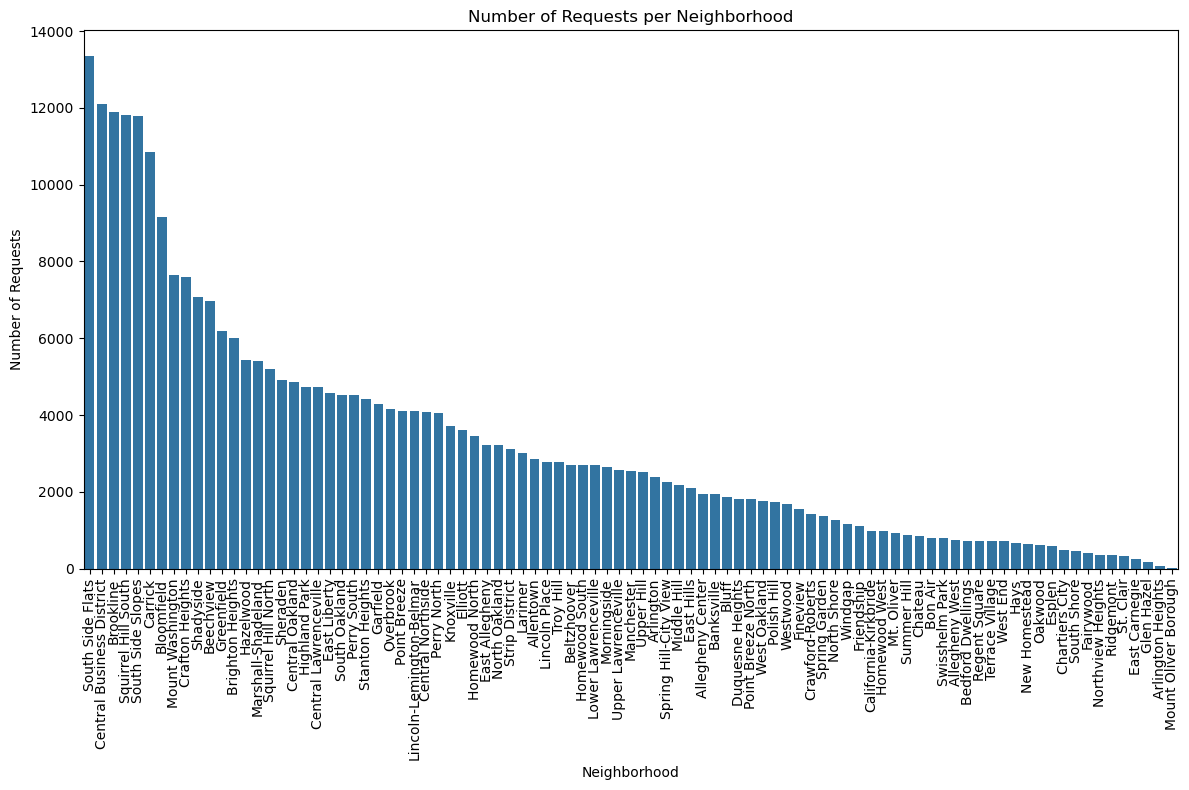

In [19]:
# number of requests vs neighborhood
requests_neigh = df_2225.groupby('neighborhood').size().reset_index(name='num_requests')
requests_neigh = requests_neigh.sort_values(by='num_requests', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=requests_neigh, x='neighborhood', y='num_requests')

plt.title('Number of Requests per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Requests')
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

C:\Users\santo\AppData\Local\Temp\ipykernel_27300\2777678971.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


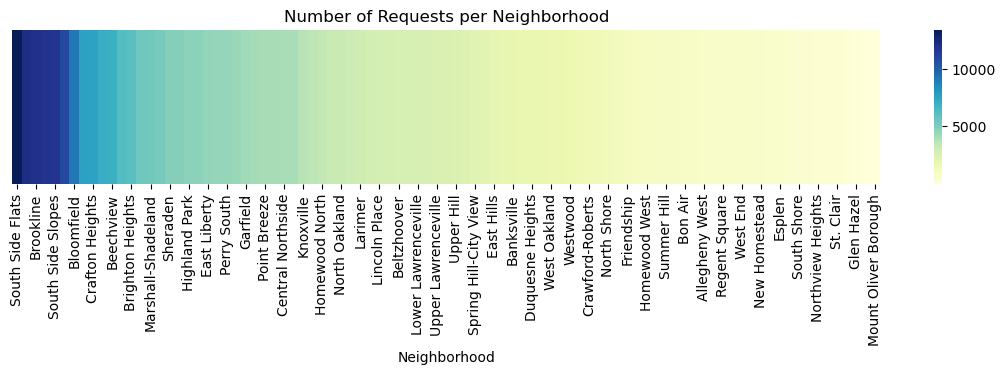

In [20]:
# create heatmap_reqneigh
heatmap_data = requests_neigh.sort_values(by='num_requests', ascending=False)
heatmap_matrix = heatmap_data.set_index('neighborhood').T

plt.figure(figsize=(14, 2)) 
sns.heatmap(heatmap_matrix, cmap='YlGnBu', annot=False, fmt='d', cbar=True)

plt.title('Number of Requests per Neighborhood')
plt.xlabel('Neighborhood')
plt.yticks([])

plt.tight_layout()
plt.show()

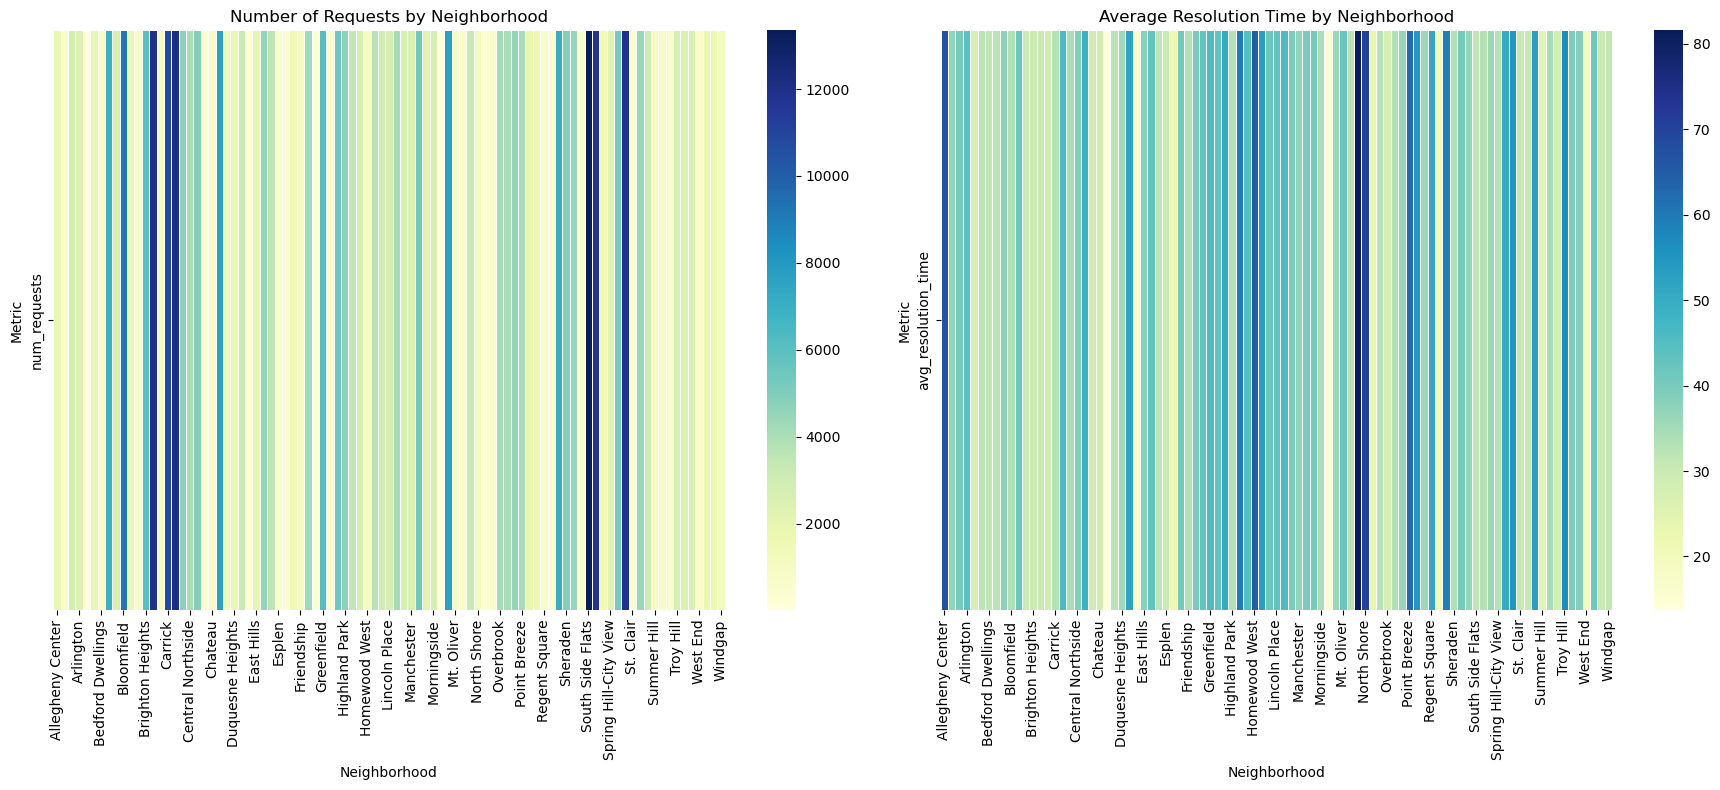

In [21]:
# heatmap of requests and resolutions by neighborhood
heatmap_reqneigh = df_2225.groupby('neighborhood').size().to_frame(name='num_requests')
heatmap_neighres = df_2225.groupby('neighborhood')['resolution_time'].mean().to_frame(name='avg_resolution_time')

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(heatmap_reqneigh.T, annot=False, cmap='YlGnBu', fmt='.0f', linewidths=0.5, ax=axes[0])
axes[0].set_title('Number of Requests by Neighborhood')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Metric')

sns.heatmap(heatmap_neighres.T, annot=False, cmap='YlGnBu', fmt='.1f', linewidths=0.5, ax=axes[1])
axes[1].set_title('Average Resolution Time by Neighborhood')
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Metric')

plt.tight_layout()

plt.show()

DESCRIPTIVE ANALYSIS - Request Type

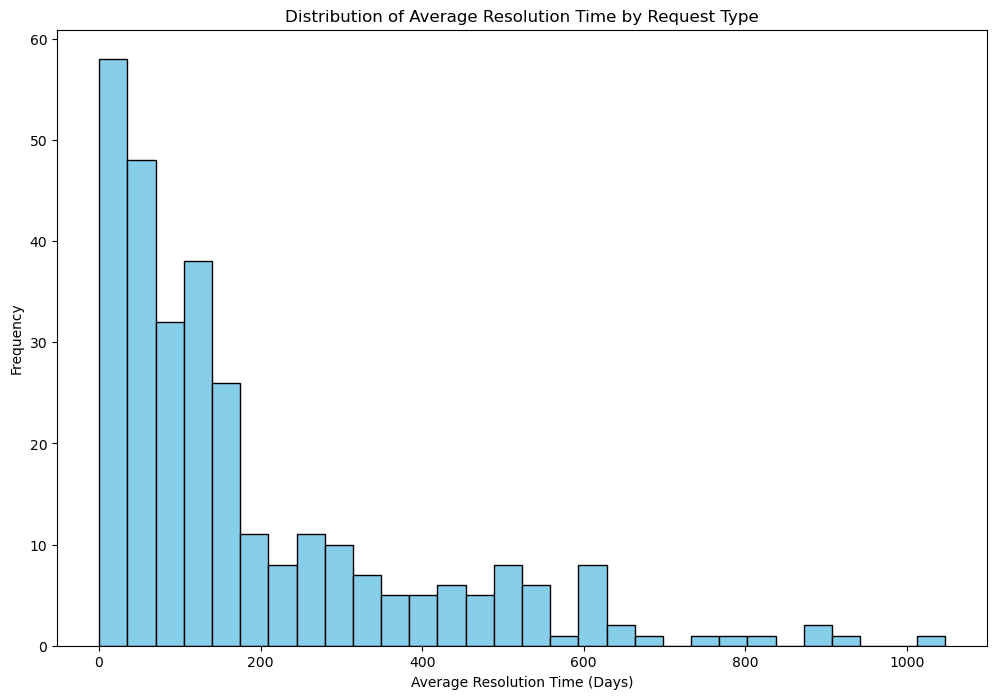


Request with highest average resolution time:
request_type_name         Building or Property Maintenance
resolution_time_filled                              1047.0
Name: 31, dtype: object


In [22]:
res_req = df_2225.groupby('request_type_name')['resolution_time_filled'].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.hist(res_req['resolution_time_filled'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Average Resolution Time by Request Type')
plt.xlabel('Average Resolution Time (Days)')
plt.ylabel('Frequency')

plt.show()

max_resolution_time_request = res_req.loc[res_req['resolution_time_filled'].idxmax()]
print("\nRequest with highest average resolution time:")
print(max_resolution_time_request)

DESCRIPTIVE ANALYSIS - 30 days or more

C:\Users\santo\AppData\Local\Temp\ipykernel_27300\2722218407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_counts, x='request_status', y='count', palette='pastel')


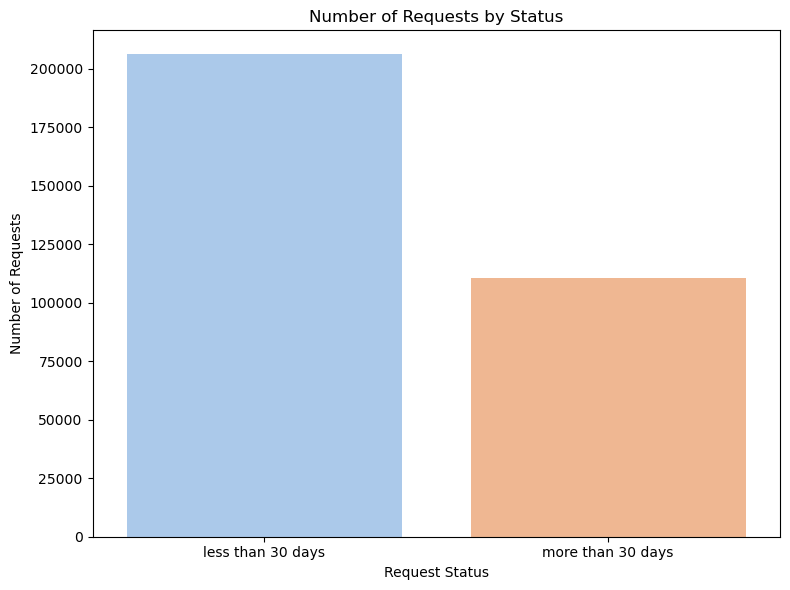

In [23]:
status_counts = df_2225['request_status'].value_counts().reset_index()
status_counts.columns = ['request_status', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(data=status_counts, x='request_status', y='count', palette='pastel')

plt.title('Number of Requests by Status')
plt.xlabel('Request Status')
plt.ylabel('Number of Requests')

plt.tight_layout()
plt.show()